In [2]:
from sqlalchemy import create_engine
import pymysql

sqlEngine       = create_engine('mysql+pymysql://root:@127.0.0.1/kaggle_hour_price', pool_recycle=3600)
dbConnection    = sqlEngine.connect()

In [3]:
%run package_import.ipynb

In [4]:
import os
os.chdir(path='/Users/liuyifu/Project_data')

In [28]:
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, SVR
from sklearn import preprocessing
import sklearn.metrics as sm
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb

### Read train data

In [6]:
df_combined = pd.read_sql_query(

''' 
select *
from transformed_combined
'''
,dbConnection)


### Prepare data for ML

In [7]:
def preprocessing_data(input: pd.DataFrame) -> np.array:
    """[summary]

    Args:
        input (pd.DataFrame): [description]

    Returns:
        np.array: [description]
    """
    
    train_rows = input[input['source']=='train'].shape[0]

    cols_selected = [i for i in input.columns if i not in ['Id', 'SalePrice']]

    X = input.loc[:, cols_selected]
    y = input.loc[:, ['SalePrice', 'source']]

    X_train = X[X['source']=='train']
    X_test = X[X['source']=='test']

    X_train.drop('source', axis=1, inplace=True)
    X_test.drop('source', axis=1, inplace=True)

    y_train = y[y['source']=='train']
    y_test = y[y['source']=='test']

    y_train.drop('source', axis=1, inplace=True)
    y_test.drop('source', axis=1, inplace=True)

    return X_train, y_train, X_test, y_test


In [9]:
X, y, X_test, y_test = preprocessing_data(df_combined)

In [ ]:
# def color_highlight_highly_corr(val):

#     threshold = 0.7

#     if abs(val) >= threshold:
#         color = 'red'
#     else:
#         color = 'black'

#     return 'color: %s' % color

# X_train.corr().style.applymap(color_highlight_highly_corr)

In [10]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, test_size=0.2, random_state=5   
)

#### Linear Regression

In [11]:
def accuracy(data: list, predict_data: list):

    print(f'Mean absolute error: {sm.mean_absolute_error(predict_data, data)}')
    print(f'Mean square error: { sm.mean_squared_error(predict_data, data)}')
    print(f'Median absolute error: {sm.median_absolute_error(predict_data, data)}')
    print(f'Explained variance score: {sm.explained_variance_score(predict_data, data)}')
    print(f'R2 score: {sm.r2_score(predict_data, data)}')

In [12]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)
y_test_pred = linear_regressor.predict(X_validate)

In [13]:
accuracy(y_test_pred, y_validate)

Mean absolute error: 4505413863836.264
Mean square error: 2.0288243730880545e+27
Median absolute error: 12644.5
Explained variance score: -4.1428646568448154e+17
R2 score: -4.1468524710489024e+17


In [ ]:
y_test_pred = pd.DataFrame(linear_regressor.predict(X_test))
df_submission = pd.read_csv('House_Prices/sample_submission.csv')
df_submission['SalePrice'] = y_test_pred
df_submission.to_csv('House_Prices/submission/house_price_linear_reg_r2_0.04.csv',index=False)

#### Ridge regression

In [14]:
# %%time
# param_grid = {'alpha': [0.01,0.1, 1, 5, 10, 15, 100, 1000]}
# ridge_grid = GridSearchCV(linear_model.Ridge(random_state=13), param_grid, cv=4)
# ridge_grid.fit(X, y)
# print(ridge_grid.best_estimator_)
# print(ridge_grid.best_params_)
# ridge_score = ridge_grid.best_score_
# print(ridge_score) 

In [15]:
ridge_regressor = linear_model.Ridge(alpha=10, fit_intercept=True, max_iter=10000)
ridge_regressor.fit(X_train, y_train)
y_test_pred = ridge_regressor.predict(X_validate)

In [16]:
cross_val_score(linear_model.Ridge(alpha=10, fit_intercept=True, max_iter=10000), X, y, scoring='r2',  cv=10)


array([0.9086622 , 0.91011965, 0.92314564, 0.72591765, 0.90255336,
       0.91181344, 0.89615993, 0.88377125, 0.89252362, 0.9023251 ])

In [17]:
accuracy(y_test_pred, y_validate)

Mean absolute error: 16917.418081479806
Mean square error: 1240532892.4417946
Median absolute error: 10718.469181862194
Explained variance score: 0.7471080028154843
R2 score: 0.7464390235706013


In [ ]:
y_test_pred = pd.DataFrame(ridge_regressor.predict(X_test))
df_submission = pd.read_csv('House_Prices/sample_submission.csv')
df_submission['SalePrice'] = y_test_pred
df_submission.to_csv('House_Prices/submission/house_price_ridge.csv',index=False)

#### Random Forest Tree

In [18]:
# %%time
# param_grid = {'n_estimators': [100, 200, 400, 500, 600, 800, 1000]}
# ridge_grid = GridSearchCV(RandomForestRegressor(random_state=13,n_jobs=-1), param_grid, cv=4)
# ridge_grid.fit(X, y)
# print(ridge_grid.best_estimator_)
# print(ridge_grid.best_params_)
# ridge_score = ridge_grid.best_score_
# print(ridge_score) 

In [19]:
RF_model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13).fit(X_train,y_train)
y_test_pred = RF_model.predict(X_validate)

/var/folders/ll/01gdbc2n2d1f47wbbx616f4r0000gn/T/ipykernel_28318/2791449992.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13).fit(X_train,y_train)


In [20]:
accuracy(y_test_pred, y_validate)

Mean absolute error: 17191.256527397258
Mean square error: 1164728720.6929746
Median absolute error: 9459.54600000001
Explained variance score: 0.7619438598207486
R2 score: 0.7619331551032358


In [25]:
cross_val_score(RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13), X, y, scoring='r2',  cv=4)


/Users/liuyifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuyifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuyifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuyifu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_valida

array([0.88569541, 0.82323477, 0.87678408, 0.87164554])

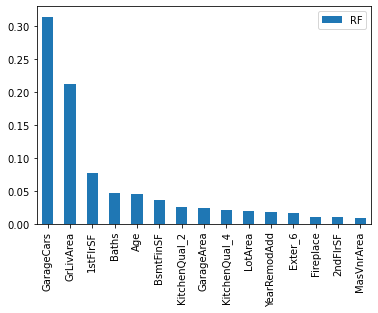

In [21]:
features = {}
for feature, importance in zip(X_train.columns, RF_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame({"RF":features})
importances.sort_values("RF", ascending = False, inplace=True)
importances[:15].plot.bar();

In [ ]:
y_test_pred = pd.DataFrame(RF_model.predict(X_test))
df_submission = pd.read_csv('House_Prices/sample_submission.csv')
df_submission['SalePrice'] = y_test_pred
df_submission.to_csv('House_Prices/submission/house_price_random_tree.csv',index=False)

### XGBoost

In [29]:
%%time
xg_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 500, seed = 13, subsample = 0.8, learning_rate = 0.1, reg_alpha=0.01, reg_lambda = 10).fit(X_train,y_train)

CPU times: user 19.6 s, sys: 3.26 s, total: 22.8 s
Wall time: 3.3 s


In [31]:
y_validate_pred = xg_model.predict(X_validate)

In [32]:
accuracy(y_test_pred, y_validate)

Mean absolute error: 17191.256527397258
Mean square error: 1164728720.6929746
Median absolute error: 9459.54600000001
Explained variance score: 0.7619438598207486
R2 score: 0.7619331551032358


In [33]:
y_test_pred = pd.DataFrame(xg_model.predict(X_test))
df_submission = pd.read_csv('House_Prices/sample_submission.csv')
df_submission['SalePrice'] = y_test_pred
df_submission.to_csv('House_Prices/submission/house_price_rxgboost.csv',index=False)